# About Neural ODE : Using `Torchdiffeq` with `Deepchem`

Author : [Anshuman Mishra](https://github.com/shivance) : [Linkedin](https://www.linkedin.com/in/anshumon/)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/About_nODE_Using_Torchdiffeq_in_Deepchem.ipynb)


Before getting our hands dirty with code , let us first understand little bit about what Neural ODEs are ?

#NeuralODEs and torchdiffeq

NeuralODE stands for "Neural Ordinary Differential Equation. You heard right. Let me guess . Your first impression of the word is : "Has it something to do with differential equations that we studied in the school ?" 

Spot on ! Let's see the formal definition as stated by the original [paper](https://arxiv.org/pdf/1806.07366.pdf) : 



```
Neural ODEs are a new family of deep neural network models. Instead of specifying a discrete sequence of 
hidden layers, we parameterize the derivative of the hidden state using a neural network.

The output of the network is computed using a blackbox differential equation solver.These are continuous-depth models that have constant memory 
cost, adapt their evaluation strategy to each input, and can explicitly trade numerical precision for speed.
```


In simple words perceive NeuralODEs as yet another type of layer like Linear, Conv2D, MHA...



In this tutorial we will be using [torchdiffeq](https://github.com/rtqichen/torchdiffeq). This library provides ordinary differential equation (ODE) solvers implemented in PyTorch framework. The library provides a clean API of ODE solvers for usage in deep learning applications. As the solvers are implemented in PyTorch, algorithms in this repository are fully supported to run on the GPU.


## What will you learn after completing this tutorial ?



1.   How to implement a Neural ODE in a Neural Network ?
2.   Using torchdiffeq with deepchem.



### Installing Libraries

In [1]:
!pip install torchdiffeq
!pip install --pre deepchem

     |████████████████████████████████| 608 kB 8.9 MB/s 
     |████████████████████████████████| 20.6 MB 8.2 MB/s 


### Import Libraries

In [2]:
import torch
import torch.nn as nn

from torchdiffeq import odeint
import math
import numpy as np

import deepchem as dc
import matplotlib.pyplot as plt

Before diving into the core of this tutorial , let's first acquaint ourselves with usage of torchdiffeq. Let's solve following differential equation .

$ \frac{dz(t)}{dt} = f(t) = t $

when $z(0) = 0$

The process to do it by hand is :

$\int dz = \int tdt+C　\\\ z(t) = \frac{t^2}{2} + C$


 
Let's solve it using ODE Solver called `odeint` from torchdiffeq

In [3]:
def f(t,z):
  return t

z0 = torch.Tensor([0])
t = torch.linspace(0,2,100)
out = odeint(f, z0, t);

Let's plot our result .It should be a parabola (remember general equation of parabola as $x^2 = 4ay$ )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


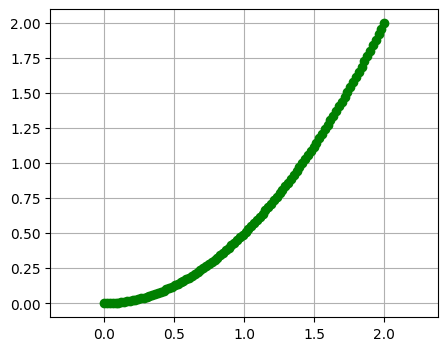

In [4]:
plt.figure(figsize=(5,4))
plt.plot(t.numpy(), out.numpy(), 'go--')
plt.gca().set_aspect('equal','datalim')
plt.grid()
plt.show()

# What is Neural Differential Equation ?

A neural differential equation is a differential equation using a neural network to parameterize the vector field. The canonical example is a neural ordinary differential equation :

$y(0) = y_0$

$\frac{dy}{dt} (t) = f_\theta(t,y(t)) $

Here θ represents some vector of learnt parameters, $ f_\theta : \mathbb{R} \times \mathbb{R}^{d_1 \times ... \times d_k}$ is any standard neural architecture and $ y:[0, T] → \mathbb{R}^{d_1 \times ... d_k} $ is the solution. For many applications $f_\theta$ will just be a simple feedforward network. Here $d_i $ is the dimension. 


[Reference](https://arxiv.org/pdf/2202.02435.pdf)

The central idea now is to use a differential equation solver as part of a learnt differentiable computation graph (the sort of computation graph ubiquitous to deep
learning)

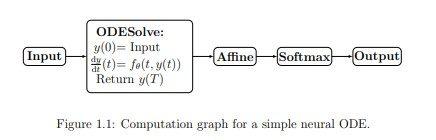


As simple example, suppose we observe some picture $y_0 \in \mathbb{R}^{3 \times 32 \times 3}$ (RGB and 32x32 pixels), and wish to classify it as a picture of a cat or as a picture of a dog.
 
 

With torchdiffeq , we can solve even complex higher order differential equations too. Following is a real world example , a set of differential equations that models a spring - mass damper system

$\dot{x}= \frac{dx}{dt} $

$\ddot{x} = -(k/m) x + p \dot{x} $

$\dddot{x} = -r \ddot{x} + gx$

with initial state t=0 , x=1



$$
\left[ \begin{array}{c} \dot{x} \\\ \ddot{x} \\\ \dddot{x} \end{array} \right] = \left[\begin{array}{cc} 0 & 1 & 0\\\ -\frac{k}{m} & p & 0\\\ 0 & g & -r \end{array} \right]
\left[ \begin{array}{c} x \\\ \dot{x}\\\ \ddot{x} \\\ \end{array} \right]
$$

The right hand side may be regarded as a particular differentiable computation graph. The parameters may be fitted by setting up a loss between the trajectories of the model and the observed trajectories in the data, backpropagating through the model, and applying stochastic gradient descent.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


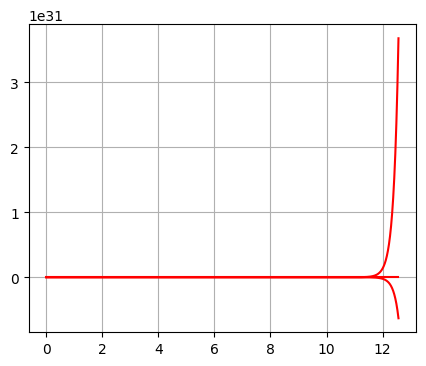

In [5]:
class SystemOfEquations:

  def __init__(self, km, p, g, r):
    self.mat = torch.Tensor([[0,1,0],[-km, p, 0],[0,g,-r]])

  def solve(self, t, x0, dx0, ddx0):
    y0 = torch.cat([x0, dx0, ddx0])
    out = odeint(self.func, y0, t)
    return out
  
  def func(self, t, y):
    out = y@self.mat 
    return out


x0 = torch.Tensor([1])
dx0 = torch.Tensor([0])
ddx0 = torch.Tensor([1])

t = torch.linspace(0, 4*np.pi, 1000)
solver = SystemOfEquations(1,6,3,2)
out = solver.solve(t, x0, dx0, ddx0)

plt.figure(figsize=(5,4))
plt.plot(t.numpy(), out.numpy(), 'r')
plt.grid()
plt.show()

This is precisely the same procedure as the more general neural ODEs we introduced
earlier. At first glance, the NDE approach of ‘putting a neural network in a differential
equation’ may seem unusual, but it is actually in line with standard practice. All that
has happened is to change the parameterisation of the vector field.

# Model

### Let us have a look at how to embed an ODEsolver in a neural network .


In [6]:
from torchdiffeq import odeint_adjoint as odeadj

class f(nn.Module):
  def __init__(self, dim):
    super(f, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(dim,124),
        nn.ReLU(),
        nn.Linear(124,124),
        nn.ReLU(),
        nn.Linear(124,dim),
        nn.Tanh()
    )

  def forward(self, t, x):
    return self.model(x)

`function` f in above code cell , is wrapped in an `nn.Module` (see codecell below) thus forming the dynamics of $\frac{dy}{dt} (t) = f_\theta(t,y(t)) $ embedded within a neural Network.
 ODE Block treats the received input x as the initial value of the differential equation. The integration interval of ODE Block is fixed at [0, 1]. And it returns the output of the layer at $ t = 1 $.

In [7]:
class ODEBlock(nn.Module):
  
  # This is ODEBlock. Think of it as a wrapper over ODE Solver , so as to easily connect it with our neurons !

  def __init__(self, f):
    super(ODEBlock, self).__init__()
    self.f = f
    self.integration_time = torch.Tensor([0,1]).float()

  def forward(self, x):
    self.integration_time = self.integration_time.type_as(x)
    out = odeadj(
        self.f,
        x,
        self.integration_time
    )

    return out[1]


class ODENet(nn.Module):
  
  #This is our main neural network that uses ODEBlock within a sequential module

  def __init__(self, in_dim, mid_dim, out_dim):
    super(ODENet, self).__init__()
    fx = f(dim=mid_dim)
    self.fc1 = nn.Linear(in_dim, mid_dim)
    self.relu1 = nn.ReLU(inplace=True)
    self.norm1 = nn.BatchNorm1d(mid_dim)
    self.ode_block = ODEBlock(fx)
    self.dropout = nn.Dropout(0.4)
    self.norm2 = nn.BatchNorm1d(mid_dim)
    self.fc2 = nn.Linear(mid_dim, out_dim)

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)

    out = self.fc1(x)
    out = self.relu1(out)
    out = self.norm1(out)
    out = self.ode_block(out)
    out = self.norm2(out)
    out = self.dropout(out)
    out = self.fc2(out)

    return out

As mentioned before , Neural ODE Networks acts similar (has advantages though) to other neural networks , so we can solve any problem with them as the existing models do. We are gonna reuse the training process mentioned in [this](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Creating_Models_with_TensorFlow_and_PyTorch.ipynb) deepchem tutorial.

So Rather than demonstrating how to use NeuralODE model with a normal dataset, we shall use the **Delaney solubility dataset** provided under **deepchem** . Our model will learn to predict the solubilities of molecules based on their extended-connectivity fingerprints (ECFPs) . For performance metrics we use [pearson_r2_score](https://deepchem.readthedocs.io/en/latest/api_reference/metrics.html#deepchem.metrics.pearson_r2_score) . Here loss is computed directly from the model's output

In [8]:
tasks, dataset, transformers = dc.molnet.load_delaney(featurizer='ECFP', splitter='random')
train_set, valid_set, test_set = dataset
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

## Time to Train

We train our model for 50 epochs, with L2 as Loss Function.

In [9]:
# Like mentioned before one can use GPUs with PyTorch and torchdiffeq
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = ODENet(in_dim=1024, mid_dim=1000, out_dim=1).to(device)
model = dc.models.TorchModel(model, dc.models.losses.L2Loss())

model.fit(train_set, nb_epoch=50)

print('Training set score : ', model.evaluate(train_set,[metric]))
print('Test set score : ', model.evaluate(test_set,[metric]))

Training set score :  {'pearson_r2_score': 0.9708644701066554}
Test set score :  {'pearson_r2_score': 0.7104556551957734}


Neural ODEs are invertible neural nets [Reference](https://proceedings.mlr.press/v119/zhang20h.html#:~:text=Neural%20ODEs%20and%20i%2DResNets,.approximate%20any%20continuous%20invertible%20mapping.)
Invertible neural networks have been a significant thread of research in the ICML community for several years. Such transformations can offer a range of unique benefits: 



*   They preserve information, allowing perfect reconstruction (up to numerical limits) and obviating the need to store hidden activations in memory for backpropagation.  
*    They are often designed to track the changes in probability density that applying the transformation induces (as in normalizing flows). 
* Like autoregressive models, [normalizing flows](https://arxiv.org/pdf/2006.00104.pdf) can be powerful generative models which allow exact likelihood computations; with the right architecture, they can also allow for much cheaper sampling than autoregressive models. 

While many researchers are aware of these topics and intrigued by several high-profile papers, few are familiar enough with the technical details to easily follow new developments and contribute. Many may also be unaware of the wide range of applications of invertible neural networks, beyond generative modelling and variational inference.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!